In [16]:
#'##########################################################
#	  	 MODEL SELECTION
#'##########################################################

set.seed(1)

rm(list=ls())

# Define necessary packages
need_pkgs <- c("tidyverse", "plotMCMC", "mcmcr", "MuMIn", "MCMCglmm","MuMIn")

exist_pckgs<-exist_pckgs <- installed.packages()[, "Package"]

if (any(!need_pkgs %in% exist_pckgs)) {   # Check for inexisting packages and install them
  install.packages(need_pkgs[!need_pkgs %in% exist_pckgs])
}


In [17]:
# load non-existing packages
lapply(need_pkgs, require, character.only = TRUE)

rm(list=ls())

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

In [18]:

#'===========================================================
# ----- LOAD data ready for GLMM analyses ----
# GLMM data contains:
#  - Data model
#  - subtree_Animals - Phylogenetic tree for Animals ready for analysis
#  - subtree_Animals - Phylogenetic tree for Plants ready for analysis
#'===========================================================
# Download data In Google colab
dir.create(file.path("Data"), showWarnings = FALSE) # Will return warning message if folder already exists
GLMMdata_link<-"https://github.com/Ecosantos/Demogbuff-pops/raw/refs/heads/incorporating-MCMCGlmm/Data/GLMMdata.Rdata"
download.file(GLMMdata_link, "Data/GLMMdata.Rdata", mode = "wb")


load("Data/GLMMdata.Rdata")

data_model%>%glimpse()


Rows: 134
Columns: 25
$ ID                   <chr> "Urs2.183_726", "Flcn.170_257", "Lgps.394_383", "…
$ Reproduction_SigElas <dbl> 1.364528e-04, -1.938652e-03, -2.377753e-02, -1.02…
$ Growth_SigElas       <dbl> 7.525562e-04, 0.000000e+00, 0.000000e+00, 0.00000…
$ Shrinking_SigElas    <dbl> 4.928246e-04, 0.000000e+00, 0.000000e+00, 0.00000…
$ Clonality_SigElas    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ Survival_SigElas     <dbl> -1.692481e-02, -7.611464e-03, -8.279373e-02, -9.8…
$ Cumulative_SigElas   <dbl> 0.0155429721, 0.0095501157, 0.1065712526, 0.10840…
$ Buffmx               <dbl> 1.0205700, 1.0084916, 1.1488676, 1.1131551, 1.017…
$ MatRep               <int> 5, 5, 5, 6, 5, 3, 3, 4, 9, 11, 3, 3, 4, 4, 53, 4,…
$ LHPC.1               <dbl> 4.0555225, -2.9624200, -3.5976811, 1.6025393, 1.0…
$ LHPC.2               <dbl> -0.69666310, -0.12995466, 0.73974502, -0.61097725…
$ ClimPC.1             <dbl> 3.3882768, -0.2612499, 0.1603933, 0.1603933, -0.5…
$ ClimPC.2        

In [19]:


#'===========================================================
# ---- Define priors ----
#'===========================================================


prior_phylo<-list(G=list(G1=list(V=1,nu=0.02)),
                  R=list(V=1,nu=0.02))

# Prior for simple model will be removed.
# It will run with prior_phylo for standardization!
#prior_simple<-list(G=list(R=list(V=1,nu=0.02)))

nitt=100000; #nitt=1000
burnin=1000; #burnin=100
thin=10

glmmScale<-"FALSE"

#'===========================================================
# ---- Create models manually ----
#'===========================================================
# A function was created to reduce code
fit_mcmcglmm <- function(formula) {
  MCMCglmm(
    formula,
    random = ~phylo,
    family = "gaussian",
    ginverse = list(phylo = inverseA(subtree_Plants, nodes = "TIPS", scale = TRUE)$Ainv),
    prior = prior_phylo,
    data = subset(data_model, Kingdom == "Plantae"),
    nitt = nitt,
    burnin = burnin,
    thin = thin,
    singular.ok = TRUE,
    scale = glmmScale,
    verbose=FALSE
  )
}


# Models all interactions
Clim123_allint <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 * ClimPC.1 * ClimPC.2 * ClimPC.3);print("Clim12_allint - OK")
Clim12_allint <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 * ClimPC.1 * ClimPC.2);print("Clim12_allint - OK")

# Models with interactions
Clim123 <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 * ClimPC.2 * ClimPC.3);print("Clim123 - OK")
Clim12 <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 * ClimPC.2);print("Clim12 - OK")
Clim13 <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 * ClimPC.3);print("Clim13 - OK")
Clim23 <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.2 * ClimPC.3);print("Clim23 - OK")

#Aditive models
Clim123_plus<-fit_mcmcglmm(Cumulative_SigElas~LHPC.1 * LHPC.2 + ClimPC.1 + ClimPC.2 + ClimPC.3);print("Clim123_plus - OK")
Clim12_plus<-fit_mcmcglmm(Cumulative_SigElas~LHPC.1 * LHPC.2 + ClimPC.1 + ClimPC.2);print("Clim12_plus - OK")

# Aditive for life history and climatic data
Clim12_plus_only<-fit_mcmcglmm(Cumulative_SigElas~LHPC.1 + LHPC.2 + ClimPC.1 + ClimPC.2);print("Clim12 plus_only - OK")

# Models with single climatic variable
Clim1 <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1);print("Clim1 - OK")
Clim2 <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.2);print("Clim2 - OK")
Clim3 <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.3);print("Clim3 - OK")

# Null model
All_null <- fit_mcmcglmm(Cumulative_SigElas ~ 1 );print("all_NULL - OK")
Clim_null <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 );print("Clim_NULL - OK")




[1] "Clim12_allint - OK"
[1] "Clim12_allint - OK"
[1] "Clim123 - OK"
[1] "Clim12 - OK"
[1] "Clim13 - OK"
[1] "Clim23 - OK"
[1] "Clim123_plus - OK"
[1] "Clim12_plus - OK"
[1] "Clim12 plus_only - OK"
[1] "Clim1 - OK"
[1] "Clim2 - OK"
[1] "Clim3 - OK"
[1] "all_NULL - OK"
[1] "Clim_NULL - OK"


In [20]:
forms<-lapply(
  lapply(
    list(All_null,Clim_null,
         Clim1,Clim2,Clim3,
         Clim123,
         Clim12,Clim13,Clim23,
         Clim123_plus,Clim12_plus,
         Clim12_plus_only,
         Clim123_allint,Clim123_allint),formula),
          function(f) paste(deparse(formula(f)), collapse = ""))%>%do.call(rbind,.)

mod_out<-cbind(formulas=forms,
  BIC(All_null,Clim_null,Clim1,Clim2,Clim3,Clim123,Clim12,Clim13,Clim23,Clim123_plus,Clim12_plus,Clim12_plus_only,Clim123_allint,Clim12_allint),
  AIC=AIC(All_null,Clim_null,Clim1,Clim2,Clim3,Clim123,Clim12,Clim13,Clim23,Clim123_plus,Clim12_plus,Clim12_plus_only,Clim123_allint,Clim12_allint)[,2],
  DIC=DIC(All_null,Clim_null,Clim1,Clim2,Clim3,Clim123,Clim12,Clim13,Clim2,Clim123_plus,Clim12_plus,Clim12_plus_only,Clim123_allint,Clim12_allint)[,2])%>%
  arrange(DIC)

mod_out


Clim12%>%summary()


# Compare some models if necessary
#summary(Clim123)
#summary(Clim123_plus)
#summary(Clim12_plus)
#summary(Clim1)
#summary(Clim12)
#summary(Clim13)


,formulas,df,BIC,AIC,DIC
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Clim12,Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 * ClimPC.2,9,-387.7937,-412.9558,-400.7529
Clim123,Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 * ClimPC.2 * ClimPC.3,13,-371.5513,-407.8966,-396.5775
All_null,Cumulative_SigElas ~ 1,3,-376.2432,-384.6306,-384.2591
Clim3,Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.3,7,-412.7078,-432.2783,-379.2992
Clim2,Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.2,7,-421.5310,-441.1015,-376.4730
Clim23,Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.2 * ClimPC.3,9,-416.1847,-441.3468,-376.4730
Clim12_plus_only,Cumulative_SigElas ~ LHPC.1 + LHPC.2 + ClimPC.1 + ClimPC.2,7,-420.8719,-440.4424,-376.1849
Clim12_plus,Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 + ClimPC.2,8,-413.9262,-436.2925,-373.1743
Clim123_plus,Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 + ClimPC.2 + ClimPC.3,9,-409.0676,-434.2297,-372.6623



 Iterations = 1001:99991
 Thinning interval  = 10
 Sample size  = 9900 

 DIC: -400.7529 

 G-structure:  ~phylo

      post.mean l-95% CI u-95% CI eff.samp
phylo    0.1992   0.1261   0.3208    25.31

 R-structure:  ~units

      post.mean  l-95% CI u-95% CI eff.samp
units  0.003015 0.0008071 0.003397    12.63

 Location effects: Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 * ClimPC.2 

                   post.mean   l-95% CI   u-95% CI eff.samp  pMCMC  
(Intercept)        0.0704309 -0.2822535  0.4034406 10013.76 0.6655  
LHPC.1            -0.0109006 -0.0215486  0.0002688   308.29 0.0347 *
LHPC.2            -0.0061356 -0.0252131  0.0125140   225.91 0.5129  
ClimPC.1           0.0174804 -0.0165294  0.0537493   753.33 0.3224  
ClimPC.2           0.0358635  0.0110577  0.0637833   875.68 0.0192 *
LHPC.1:LHPC.2      0.0067587 -0.0036021  0.0177519    52.15 0.1509  
ClimPC.1:ClimPC.2  0.0141764 -0.0069436  0.0363963   116.92 0.1677  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘

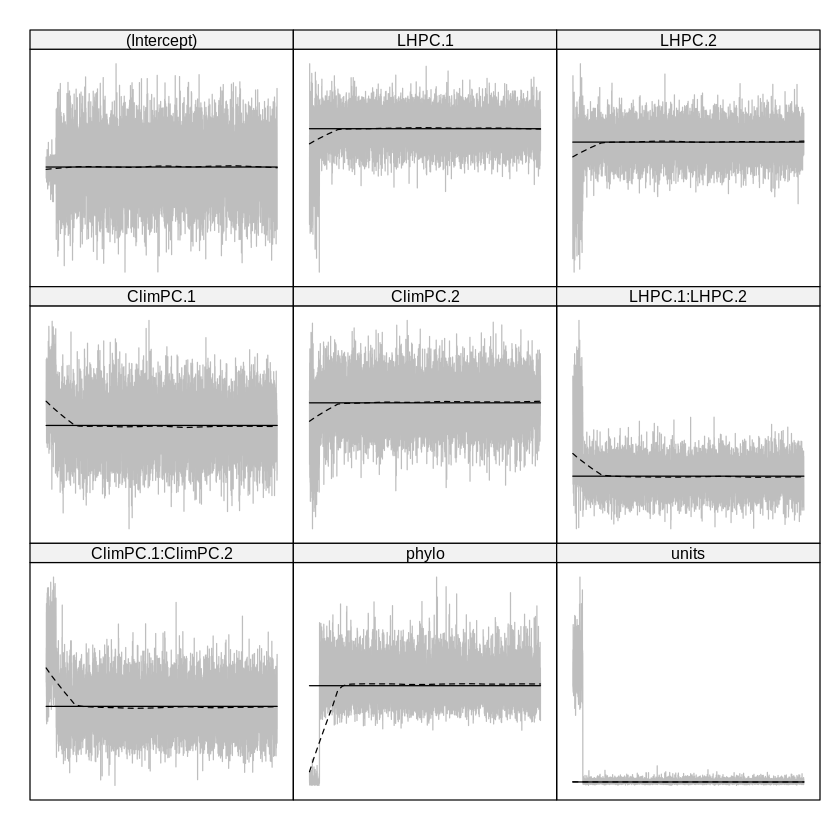

In [21]:
allChains <- mcmcr::as.mcmc(cbind(Clim12$Sol,Clim12$VCV))
plotMCMC::plotTrace(allChains)